In [3]:
import Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `~/.julia/dev/thesis`


In [139]:
using RxInferThesisExperiments, RxInfer, StaticArrays, Plots, LinearAlgebra, StableRNGs, Random, BenchmarkTools

In [54]:
# Hot fixes for `ReactiveMP`
ReactiveMP.cholinv(x::UniformScaling) = inv(x.λ) * I
ReactiveMP.cholinv(x::SMatrix) = inv(x)
ReactiveMP.fastcholesky(x::SMatrix) = ReactiveMP.fastcholesky(Matrix(x))

In [127]:
const environment = DoublePendulum(γ = 5.0)

DoublePendulum()

In [128]:
f(state) = state_transition(environment)(state)

f (generic function with 1 method)

In [129]:
@model function double_pendulum(T, z_start)
    
    z = randomvar(T)
    y = datavar(Float64, T)
    σ ~ Gamma(0.001, 100.0)
    
    Σ = constvar(SMatrix{4, 4}(1000 * diageye(4)))
    c = constvar(SA[ 0.0, 1.0, 0.0, 0.0 ])
    
    z[1] ~ MvNormal(mean = z_start, covariance = SMatrix{4, 4}(diageye(4)))
    y[1] ~ Normal(mean = dot(z[1], c), precision = σ)
    
    for t in 2:T
        z[t] ~ MvNormal(mean = f(z[t - 1]), precision = Σ)
        y[t] ~ Normal(mean = dot(z[t], c), precision = σ)
    end
end

@meta function double_pendulum_meta()
    f() -> Linearization()
end

@constraints function double_pendulum_constraints()
    q(z, σ) = q(z)q(σ)
end

double_pendulum_constraints (generic function with 1 method)

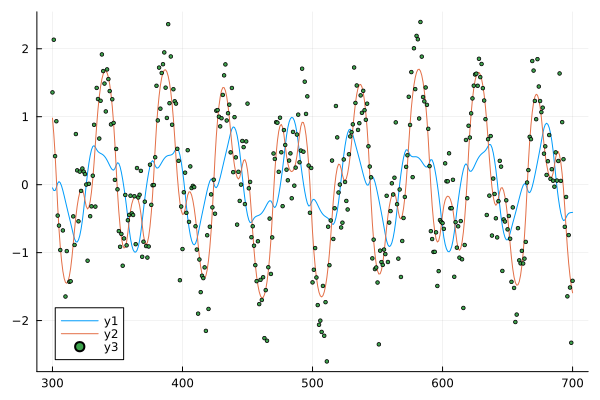

In [134]:
T = 5000

states, observations = rand(environment, T);

# RxInferThesisExperiments.animate_double_pendulum(states[1:min(100, lastindex(states))])

prange = 300:700
# prange = firstindex(states):lastindex(states)

plot(prange, getindex.(states, 1)[prange])
plot!(prange, getindex.(states, 2)[prange])
scatter!(prange, observations[prange], ms = 2)

In [135]:
results = inference(
    model = double_pendulum(T, states[begin]),
    data = (y = observations, ),
    meta = double_pendulum_meta(),
    constraints = double_pendulum_constraints(),
    returnvars = (z = KeepLast(), σ = KeepLast()),
    iterations = 2,
    initmarginals = (σ = Gamma(0.001, 100.0), ),
    options = (limit_stack_depth = 500, )
)

Inference results:
  Posteriors       | available for (σ, z)


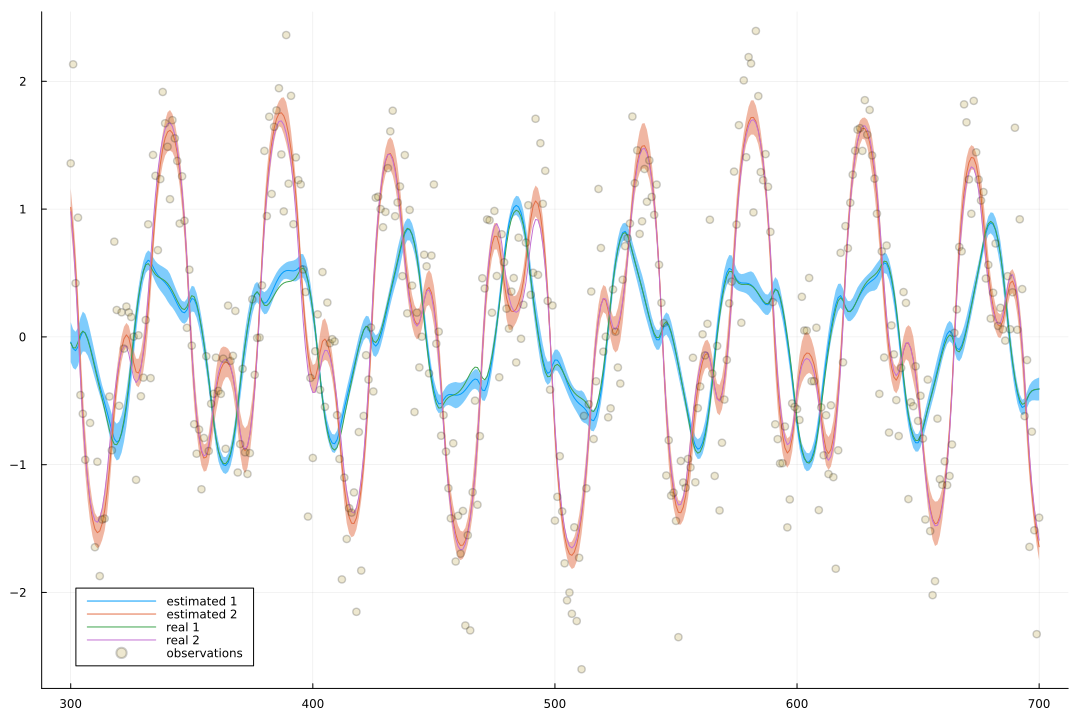

In [136]:
em = mean.(results.posteriors[:z])
ev = std.(results.posteriors[:z])
p = plot(size=(1080, 720))
plot!(prange, getindex.(em, 1)[prange], ribbon = getindex.(ev, 1, 1), label = "estimated 1")
plot!(prange, getindex.(em, 2)[prange], ribbon = getindex.(ev, 2, 2), label = "estimated 2")
plot!(prange, getindex.(states, 1)[prange], label = "real 1")
plot!(prange, getindex.(states, 2)[prange], label = "real 2")
scatter!(prange, getindex.(observations, 1)[prange], ms = 4, alpha = 0.2, label = "observations")

In [138]:
GC.gc(true)
benchmark = @benchmark inference(
    model = double_pendulum($T, $(states[begin])),
    data = (y = $observations, ),
    meta = double_pendulum_meta(),
    constraints = double_pendulum_constraints(),
    returnvars = (z = KeepLast(), σ = KeepLast()),
    iterations = 2,
    initmarginals = (σ = Gamma(0.001, 1000.0), ),
    options = (limit_stack_depth = 500, )
)
GC.gc(true)
benchmark

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.070 s …   1.249 s  ┊ GC (min … max): 37.52% … 45.08%
 Time  (median):     1.155 s              ┊ GC (median):    39.37%
 Time  (mean ± σ):   1.157 s ± 63.598 ms  ┊ GC (mean ± σ):  40.72% ±  3.31%

  █                       █ █   █                         █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.07 s         Histogram: frequency by time        1.25 s <

 Memory estimate: 565.82 MiB, allocs estimate: 6023975.